<a href="https://github.com/xuehangcang/DeepLearning/blob/main/docs/PyTorch/%E5%9F%BA%E7%A1%80%E7%9F%A5%E8%AF%86/3.数据集和数据加载器.ipynb" download=""><svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="110" height="20" role="img" aria-label="jupyter: notebook"><title>jupyter: notebook</title><linearGradient id="s" x2="0" y2="100%"><stop offset="0" stop-color="#bbb" stop-opacity=".1"/><stop offset="1" stop-opacity=".1"/></linearGradient><clipPath id="r"><rect width="110" height="20" rx="3" fill="#fff"/></clipPath><g clip-path="url(#r)"><rect width="49" height="20" fill="#555"/><rect x="49" width="61" height="20" fill="#fe7d37"/><rect width="110" height="20" fill="url(#s)"/></g><g fill="#fff" text-anchor="middle" font-family="Verdana,Geneva,DejaVu Sans,sans-serif" text-rendering="geometricPrecision" font-size="110"><text aria-hidden="true" x="255" y="150" fill="#010101" fill-opacity=".3" transform="scale(.1)" textLength="390">jupyter</text><text x="255" y="140" transform="scale(.1)" fill="#fff" textLength="390">jupyter</text><text aria-hidden="true" x="785" y="150" fill="#010101" fill-opacity=".3" transform="scale(.1)" textLength="510">notebook</text><text x="785" y="140" transform="scale(.1)" fill="#fff" textLength="510">notebook</text></g></svg></a>

### 3.1 数据集和数据加载器

处理数据样本的代码可能会变得混乱和难以维护；我们最好将我们的数据集代码与我们的模型训练代码解耦，以提高可读性和模块化。

PyTorch提供了两个数据基元：`torch.utils.data.DataLoader` 和 `torch.utils.data.Dataset` ，它们允许您使用预加载的数据集以及您自己的数据。

`Dataset` 存储样本及其相应的标签，`DataLoader` 将可迭代对象包装在 `Dataset` 周围，以便轻松访问样本。

PyTorch领域库提供了许多预加载的数据集，它们是 `torch.utils.data.Dataset` 的子类，并实现特定于特定数据的函数。

它们可用于原型设计和模型基准测试。您可以在这里找到它们：

- [图像数据集](https://pytorch.org/vision/stable/datasets.html)
- [文本数据集](https://pytorch.org/text/stable/datasets.html)
- [音频数据集](https://pytorch.org/audio/stable/datasets.html)



## 3.2 加载数据集

以下是如何从 TorchVision 加载 [Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist) 数据集的示例。

Fashion-MNIST 是 Zalando 衣服图片的数据集，包括 60,000 个训练样本和 10,000 个测试样本。

每个样本包括一个28×28的灰度图像和一个属于10个类别之一的相关标签。

我们使用以下参数加载 `FashionMNIST数据集`：
 - `root`是训练/测试数据存储的路径
 - `train`指定训练或测试数据集
 - `download=True`如果在`root`中没有数据，则从互联网下载数据
 - `transform`和`target_transform`指定特征和标签变换

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



##  3.3 迭代和可视化数据集

我们可以像处理列表一样手动索引“数据集”：`training_data[index]`。

我们使用`matplotlib`来可视化训练数据中的一些样本。


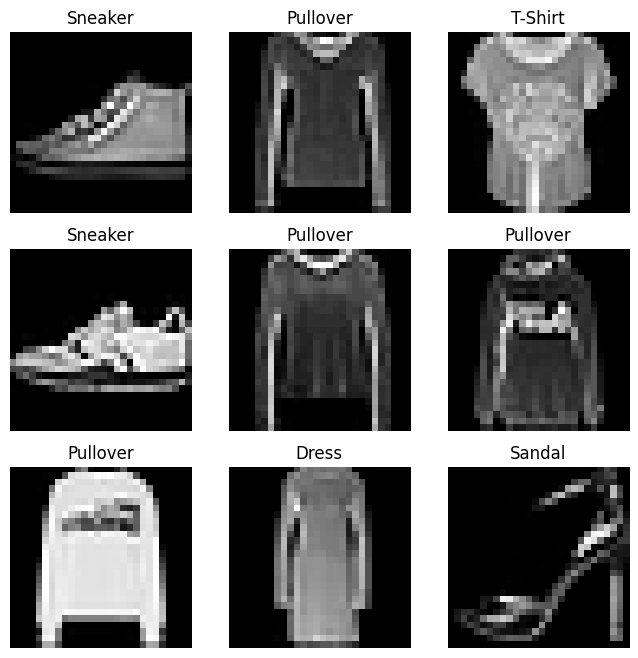

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 3.4 为您的文件创建自定义数据集

自定义数据集类必须实现三个函数：`__init__`，`__len__`和`__getitem__`。

看看这个实现，FashionMNIST图像存储在一个名为 `img_dir` 的目录中，它们的标签分别存储在CSV文件 `annotations_file`  中。

在下面的几个部分中，我们将分解每个函数中发生的事情。

In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### 3.4.1 __init__

__init__函数在实例化Dataset对象时运行一次。我们初始化包含图片的目录、注释文件以及两个转换操作。

labels.csv文件格式如下:

- tshirt1.jpg, 0
- tshirt2.jpg, 0
- ......
- ankleboot999.jpg, 9

In [4]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### 3.4.2 __len__

__len__函数返回数据集中样本的数量。

示例：

In [5]:
def __len__(self):
    return len(self.img_labels)

### 3.4.3 __getitem__

__getitem__ 函数根据给定的索引 "idx" 从数据集中加载并返回样本。

根据索引，它确定磁盘上图像的位置，使用 `read_image` 将其转换为张量，从 `self.img_labels` 中检索相应的 csv 数据中的标签，对它们进行转换并返回张量图像和相应的标签的元组。

In [6]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label


## 3.5 使用 DataLoaders 准备训练数据


`数据集`一次只能检索一个样本的特征和标签。在训练模型时，我们通常希望以`小批量`传递样本，每个 epoch 重新洗牌数据以减少模型过拟合，并使用 Python 的`多进程`加速数据检索。

`DataLoader` 是一个可迭代对象，它在易于使用的 API 中为我们抽象了这个复杂性。

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## 3.6 通过DataLoader迭代

我们已经将数据集加载到 `DataLoader` 中，可以根据需要迭代数据集。

下面的每次迭代返回一个批次的 `train_features` 和 `train_labels` （分别包含`batch_size = 64`个特征和标签）。

因为我们指定了`shuffle = True`，在迭代所有批次后，数据将被重新洗牌。

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


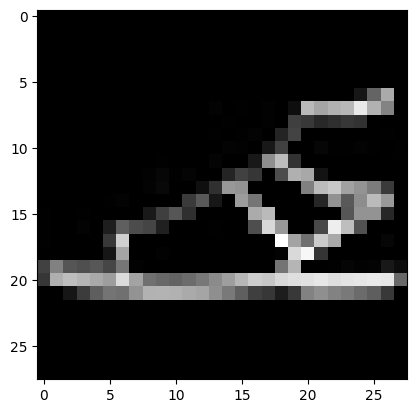

Label: 5


In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")